In [6]:
%pylab inline
%run params.py

import matplotlib.pyplot as plt
import pandas as pd
import random
import os
from scipy.stats import pearsonr
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from plotting_functions import *
from scipy.stats import ks_2samp

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [7]:
# Load data
dataset = pd.read_csv(os.path.join(DATAPATH, "constraint", "autosomal_perlocus_estimates.bed"))

In [8]:
# Look at expression by tissue
gtex = pd.read_csv(os.path.join(DATAPATH,"strsets","GTEx_Analysis_v6p_RNA-seq_RNA-SeQCv1.1.8_gene_median_rpkm.gct.gz"),
                  skiprows=2, sep="\t")
exprcols = [item for item in gtex.columns if item not in ["Description","Name"]]
gtex["gene"] = gtex["Description"]

setdata = pd.read_csv(os.path.join(DATAPATH, "strsets", "lobSTR_ref_GRCh37_coding_genes.bed.gz"), sep="\t", names=["chrom","start","end","gene"])
setdata = pd.merge(setdata, dataset, on=["chrom","start"]).drop_duplicates()
data = pd.merge(setdata, gtex, on=["gene"])
exprmatrix = data.loc[:,exprcols]

In [9]:
col="zscore_1"

corr = []
pvals = []
means = []
nums = []
kspvals = []
kspvals_ctrl = []
threshold = 80 # top X% of expressed genes

for tissue in exprcols:
    r = pearsonr(data[data[tissue]>0][col], data[data[tissue]>0][tissue])
    corr.append(r[0])
    pvals.append(r[1])
    means.append(np.mean(data[data[tissue]>0][col]))
    nums.append(data[data[tissue]>0].shape[0])
    
    # zscores for top 10%
    cutoff = np.percentile(data[data[tissue]>0][tissue], [threshold])[0]
    zhigh = data[data[tissue]>0][data[tissue]>cutoff][col]
    zlow = data[data[tissue]>0][data[tissue]<=cutoff][col]
    #print tissue, cutoff, np.mean(zhigh)-np.mean(zlow), len(zhigh), len(zlow), zhigh+zlow
    #print data.shape[0], len(zhigh), len(zlow), len(zhigh)+len(zlow)
    kspvals.append(ks_2samp(zhigh, zlow)[1])
    
    # Repeat, with expression shuffled
    rexpr = data[tissue].copy()
    random.shuffle(rexpr)
    zhigh = data[rexpr>cutoff][col]
    zlow = data[rexpr<=cutoff][col]
    kspvals_ctrl.append(ks_2samp(zhigh, zlow)[1])    
    
cdata = pd.DataFrame({"tissue": exprcols, "corr": corr, "pval": pvals, "meanz": means,"num":nums,
                      "ksp":kspvals, "ksp_ctrl": kspvals_ctrl})
cdata["corr2"] = cdata["corr"].apply(lambda x: x**2)
cdata = cdata[["tissue","corr","corr2","pval","meanz","num","ksp","ksp_ctrl"]]

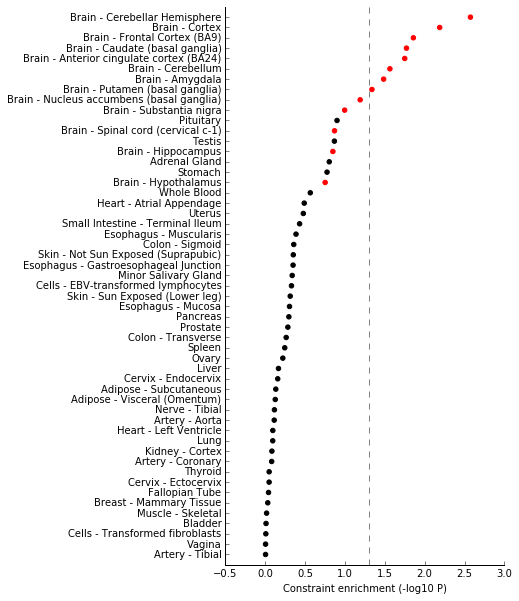

In [10]:
colors = {}
for tissue in exprcols:
    if "Brain" in tissue: colors[tissue] = "red"

cdata["color"] = cdata["tissue"].apply(lambda x: colors.get(x, "black"))
cdata = cdata.sort("ksp", ascending=False)
cdata["order"] = range(cdata.shape[0])
fig = plt.figure()
fig.set_size_inches((5,10))
ax = fig.add_subplot(111)
ax.scatter(np.log10(cdata["ksp"])*-1, cdata["order"], color=cdata["color"])
ax.axvline(x=-1*np.log10(0.05), linestyle="dashed", color="gray")
ax.set_ylim(bottom=-1, top=cdata.shape[0])
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
ax.set_yticks(cdata["order"])
ax.set_yticklabels(cdata["tissue"]);
ax.set_xlabel("Constraint enrichment (-log10 P)")
fig.savefig(os.path.join(PLOTDIR, "Figure14_ConstraintExpression.pdf"))